In [257]:
import time
import warnings
from tqdm import tqdm
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.woe import WOEEncoder

warnings.simplefilter("ignore")

In [204]:
train = pd.read_csv(
    "data/assignment_2_train.csv"
)
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27
)

In [206]:
numerical_features = x_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = x_train.select_dtypes(exclude=np.number).columns.tolist()

to_drop = [
    "isFraud",
    "TransactionID",
    "TransactionDT"
]

## 2. LightGBM

In [207]:
def create_dummy_features(train: pd.DataFrame, test: pd.DataFrame, categorical: List[str]) -> pd.DataFrame:
    """
    Создание One-Hot-Enconding признаков для категориальных
    переменных. Признаки создаются на основе объединенных
    train и test выборок, чтобы исключить потенциальные
    конфликты с отсутствием редких значений в одной
    из выборок.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    data = pd.concat([train, test], axis=0)
    data = data.reset_index(drop=True)

    if categorical:
        dummy = pd.get_dummies(
            data[categorical], prefix=categorical, dummy_na=True
        )
        dummy["TransactionID"] = data["TransactionID"]

        train_transformed = train.merge(
            dummy, how="left", on="TransactionID"
        )
        test_transformed = test.merge(
            dummy, how="left", on="TransactionID"
        )
        return train_transformed, test_transformed

def prepare_data_for_fit(train: pd.DataFrame, test: pd.DataFrame, to_drop: List[str]):
    """
    Подготовка данных для обучения модели.

    """
    object_features = train.dtypes[train.dtypes == "object"].index
    to_drop = (set(train.columns) & set(to_drop)) | set(object_features)
    to_drop = list(to_drop)

    train = train.drop(to_drop, axis=1)
    test = test.drop(to_drop, axis=1)
    
    return train, test

## 2.0. LightGBM

In [212]:
train_numerical, test_numerical = prepare_data_for_fit(
    train=x_train, test=x_valid, to_drop=to_drop+categorical_features
)
train_predictions, valid_predictions = pd.DataFrame(), pd.DataFrame()

In [211]:
lgb_params = { 
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_numerical, 
    y=y_train,
    eval_set=[(train_numerical, y_train), (test_numerical, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
train_predictions["LightGBM_numerical"] = model.predict_proba(train_numerical)[:, 1]
valid_predictions["LightGBM_numerical"] = model.predict_proba(test_numerical)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.900892	dtrain's binary_logloss: 0.0767509	dvalid's auc: 0.888616	dvalid's binary_logloss: 0.0801877
[50]	dtrain's auc: 0.925052	dtrain's binary_logloss: 0.0656762	dvalid's auc: 0.902876	dvalid's binary_logloss: 0.0720238
[75]	dtrain's auc: 0.938846	dtrain's binary_logloss: 0.0593376	dvalid's auc: 0.910937	dvalid's binary_logloss: 0.0680197
[100]	dtrain's auc: 0.949186	dtrain's binary_logloss: 0.0551273	dvalid's auc: 0.918262	dvalid's binary_logloss: 0.0654173
[125]	dtrain's auc: 0.955586	dtrain's binary_logloss: 0.0519397	dvalid's auc: 0.922609	dvalid's binary_logloss: 0.0637042
[150]	dtrain's auc: 0.960271	dtrain's binary_logloss: 0.0494334	dvalid's auc: 0.92609	dvalid's binary_logloss: 0.0623515
[175]	dtrain's auc: 0.96465	dtrain's binary_logloss: 0.0471784	dvalid's auc: 0.928238	dvalid's binary_logloss: 0.0612123
[200]	dtrain's auc: 0.968072	dtrain's binary_logloss: 0.0451917	dvalid's auc: 0.930101	dv

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.508716, importance_type='split',
               is_unbalance=False, learning_rate=0.05134, max_depth=10,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.024766, n_estimators=10000, n_jobs=-1,
               num_leaves=54, objective=None, random_state=27,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, subsample_freq=0,
               verbose=-1)

## 2.1. LightGBM + OneHotEncoding

In [30]:
train_ohe, test_ohe = create_dummy_features(
    train=x_train, test=x_valid, categorical=categorical_features
)
train_ohe, test_ohe = prepare_data_for_fit(
    train=train_ohe, test=test_ohe, to_drop=to_drop
)
lgb_models = {}

In [214]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_ohe, 
    y=y_train,
    eval_set=[(train_ohe, y_train), (test_ohe, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_ohe"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_OHE"] = model.predict_proba(train_ohe)[:, 1]
valid_predictions["LightGBM_OHE"] = model.predict_proba(test_ohe)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.911428	dtrain's binary_logloss: 0.0746648	dvalid's auc: 0.896507	dvalid's binary_logloss: 0.0785359
[50]	dtrain's auc: 0.932486	dtrain's binary_logloss: 0.0632838	dvalid's auc: 0.910724	dvalid's binary_logloss: 0.0696905
[75]	dtrain's auc: 0.948903	dtrain's binary_logloss: 0.0567966	dvalid's auc: 0.918839	dvalid's binary_logloss: 0.0657149
[100]	dtrain's auc: 0.959179	dtrain's binary_logloss: 0.0522059	dvalid's auc: 0.927482	dvalid's binary_logloss: 0.0627747
[125]	dtrain's auc: 0.965208	dtrain's binary_logloss: 0.0488513	dvalid's auc: 0.932532	dvalid's binary_logloss: 0.0606681
[150]	dtrain's auc: 0.969317	dtrain's binary_logloss: 0.046384	dvalid's auc: 0.936158	dvalid's binary_logloss: 0.0591104
[175]	dtrain's auc: 0.973186	dtrain's binary_logloss: 0.0440405	dvalid's auc: 0.938626	dvalid's binary_logloss: 0.0578876
[200]	dtrain's auc: 0.976753	dtrain's binary_logloss: 0.041974	dvalid's auc: 0.941183	dv

## 2.2. LightGBM + LabelEncoder

In [71]:
def create_factorized_features(train: pd.DataFrame, test: pd.DataFrame, categorical: List[str]) -> pd.DataFrame:
    """
    Создание LabelEncoded признаков для категориальных
    переменных. Признаки создаются на основе объединенных
    train и test выборок, чтобы исключить потенциальные
    конфликты с отсутствием редких значений в одной
    из выборок.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    data = pd.concat([train, test], axis=0)
    data = data.reset_index(drop=True)

    for feature in tqdm(categorical):
        encoder = LabelEncoder()
        data[f"{feature}_factorized"] = encoder.fit_transform(
            data[feature].astype("str").fillna("NA")
        )
        train = train.merge(
            data[["TransactionID", f"{feature}_factorized"]], how="left", on="TransactionID"
        )
        test = test.merge(
            data[["TransactionID", f"{feature}_factorized"]], how="left", on="TransactionID"
        )
    return train, test

In [72]:
train_le, test_le = create_factorized_features(
    train=x_train, test=x_valid, categorical=categorical_features
)
train_le, test_le = prepare_data_for_fit(
    train=train_le, test=test_le, to_drop=to_drop
)

100%|██████████| 14/14 [00:08<00:00,  1.68it/s]


In [216]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_le, 
    y=y_train,
    eval_set=[(train_le, y_train), (test_le, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_LabelEncoder"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_LabelEncoder"] = model.predict_proba(train_le)[:, 1]
valid_predictions["LightGBM_LabelEncoder"] = model.predict_proba(test_le)[:, 1]

## 2.3. LightGBM + CatBoostEncoder

In [98]:
def create_encoders_features(train: pd.DataFrame,
                             test: pd.DataFrame,
                             target: pd.Series,
                             categorical: List[str]) -> pd.DataFrame:
    """
    Создание CatBoostEncoder признаков для категориальных
    переменных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    target: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    encoder = CatBoostEncoder()
    train[categorical] = encoder.fit_transform(
        train[categorical], target
    )
    test[categorical] = encoder.transform(
        test[categorical]
    )
    return train, test

In [100]:
train_cb, test_cb = create_catboost_features(
    train=x_train, test=x_valid, target=y_train, categorical=categorical_features
)
train_cb, test_cb = prepare_data_for_fit(
    train=train_cb, test=test_cb, to_drop=to_drop
)

/Users/a17582007/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [217]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_cb, 
    y=y_train,
    eval_set=[(train_cb, y_train), (test_cb, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_CatBoostEncoder"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_CatBoostEncoder"] = model.predict_proba(train_cb)[:, 1]
valid_predictions["LightGBM_CatBoostEncoder"] = model.predict_proba(test_cb)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.911281	dtrain's binary_logloss: 0.0751413	dvalid's auc: 0.895103	dvalid's binary_logloss: 0.0789954
[50]	dtrain's auc: 0.936422	dtrain's binary_logloss: 0.0633235	dvalid's auc: 0.909539	dvalid's binary_logloss: 0.0702169
[75]	dtrain's auc: 0.952142	dtrain's binary_logloss: 0.0564514	dvalid's auc: 0.919156	dvalid's binary_logloss: 0.065973
[100]	dtrain's auc: 0.961095	dtrain's binary_logloss: 0.0520976	dvalid's auc: 0.923621	dvalid's binary_logloss: 0.0637793
[125]	dtrain's auc: 0.967131	dtrain's binary_logloss: 0.0487563	dvalid's auc: 0.927974	dvalid's binary_logloss: 0.0621466
[150]	dtrain's auc: 0.972769	dtrain's binary_logloss: 0.0458329	dvalid's auc: 0.931856	dvalid's binary_logloss: 0.0607952
[175]	dtrain's auc: 0.976394	dtrain's binary_logloss: 0.0436631	dvalid's auc: 0.933772	dvalid's binary_logloss: 0.0599114
[200]	dtrain's auc: 0.980065	dtrain's binary_logloss: 0.0414334	dvalid's auc: 0.935498	d

## 2.4. LightGBM + Target Encoder

In [131]:
def create_target_features(train: pd.DataFrame,
                           test: pd.DataFrame,
                           target: pd.Series,
                           categorical: List[str]) -> pd.DataFrame:
    """
    Создание признаков, основанных на значении целевой
    переменной, для категориальных переменных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    target: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    encoder = TargetEncoder()
    train[categorical] = encoder.fit_transform(
        train[categorical], target
    )
    test[categorical] = encoder.transform(
        test[categorical]
    )
    return train, test

In [132]:
train_te, test_te = create_target_features(
    train=x_train, test=x_valid, target=y_train, categorical=categorical_features
)
train_te, test_te = prepare_data_for_fit(
    train=train_te, test=test_te, to_drop=to_drop
)

/Users/a17582007/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [218]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_te, 
    y=y_train,
    eval_set=[(train_te, y_train), (test_te, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_TargetEncoding"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_TargetEncoding"] = model.predict_proba(train_te)[:, 1]
valid_predictions["LightGBM_TargetEncoding"] = model.predict_proba(test_te)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.909918	dtrain's binary_logloss: 0.0747453	dvalid's auc: 0.895393	dvalid's binary_logloss: 0.0786773
[50]	dtrain's auc: 0.936252	dtrain's binary_logloss: 0.062846	dvalid's auc: 0.911698	dvalid's binary_logloss: 0.0696417
[75]	dtrain's auc: 0.95087	dtrain's binary_logloss: 0.0563022	dvalid's auc: 0.922647	dvalid's binary_logloss: 0.0652066
[100]	dtrain's auc: 0.958723	dtrain's binary_logloss: 0.0522121	dvalid's auc: 0.928037	dvalid's binary_logloss: 0.0626925
[125]	dtrain's auc: 0.964823	dtrain's binary_logloss: 0.0488447	dvalid's auc: 0.932489	dvalid's binary_logloss: 0.0607594
[150]	dtrain's auc: 0.969637	dtrain's binary_logloss: 0.0461422	dvalid's auc: 0.935637	dvalid's binary_logloss: 0.059306
[175]	dtrain's auc: 0.97342	dtrain's binary_logloss: 0.0438894	dvalid's auc: 0.938145	dvalid's binary_logloss: 0.0581256
[200]	dtrain's auc: 0.976689	dtrain's binary_logloss: 0.0418898	dvalid's auc: 0.940155	dval

## 2.5. LightGBM + WOEEncoder

In [121]:
def create_woe_features(train: pd.DataFrame,
                        test: pd.DataFrame,
                        target: pd.Series,
                        categorical: List[str]) -> pd.DataFrame:
    """
    Создание CatBoostEncoder признаков для категориальных
    переменных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    target: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    encoder = WOEEncoder(random_state=27)
    train[categorical] = encoder.fit_transform(
        train[categorical], target
    )
    test[categorical] = encoder.transform(
        test[categorical]
    )
    return train, test

In [122]:
train_woe, test_woe = create_woe_features(
    train=x_train, test=x_valid, target=y_train, categorical=categorical_features
)
train_woe, test_woe = prepare_data_for_fit(
    train=train_woe, test=test_woe, to_drop=to_drop
)

/Users/a17582007/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [219]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_woe, 
    y=y_train,
    eval_set=[(train_woe, y_train), (test_woe, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_WOE"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_WOE"] = model.predict_proba(train_woe)[:, 1]
valid_predictions["LightGBM_WOE"] = model.predict_proba(test_woe)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.907448	dtrain's binary_logloss: 0.0749856	dvalid's auc: 0.893167	dvalid's binary_logloss: 0.0789686
[50]	dtrain's auc: 0.936823	dtrain's binary_logloss: 0.0628322	dvalid's auc: 0.911367	dvalid's binary_logloss: 0.0697022
[75]	dtrain's auc: 0.951297	dtrain's binary_logloss: 0.0562173	dvalid's auc: 0.921959	dvalid's binary_logloss: 0.0652948
[100]	dtrain's auc: 0.959156	dtrain's binary_logloss: 0.0520345	dvalid's auc: 0.928035	dvalid's binary_logloss: 0.0626644
[125]	dtrain's auc: 0.965281	dtrain's binary_logloss: 0.0486473	dvalid's auc: 0.932495	dvalid's binary_logloss: 0.0607426
[150]	dtrain's auc: 0.970319	dtrain's binary_logloss: 0.0458582	dvalid's auc: 0.936367	dvalid's binary_logloss: 0.0591913
[175]	dtrain's auc: 0.973568	dtrain's binary_logloss: 0.0437536	dvalid's auc: 0.938155	dvalid's binary_logloss: 0.0581819
[200]	dtrain's auc: 0.976867	dtrain's binary_logloss: 0.0416925	dvalid's auc: 0.940236	

## 2.6. LightGBM + JamesSteinEncoder

In [147]:
def create_js_features(train: pd.DataFrame,
                        test: pd.DataFrame,
                        target: pd.Series,
                        categorical: List[str]) -> pd.DataFrame:
    """
    Создание JamesSteinEncoder признаков для
    категориальных переменных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    test: pandas.core.frame.DataFrame
        Матрица признаков для валидации модели.

    target: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    categorical: List[str]
        Список категориальных признаков.

    Returns
    -------
    train_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для обучения модели.

    test_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков для валидации модели.

    """
    encoder = JamesSteinEncoder(random_state=27)
    train[categorical] = encoder.fit_transform(
        train[categorical], target
    )
    test[categorical] = encoder.transform(
        test[categorical]
    )
    return train, test

In [149]:
train_js, test_js = create_js_features(
    train=x_train, test=x_valid, target=y_train, categorical=categorical_features
)
train_js, test_js = prepare_data_for_fit(
    train=train_js, test=test_js, to_drop=to_drop
)

/Users/a17582007/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [220]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_js, 
    y=y_train,
    eval_set=[(train_js, y_train), (test_js, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_JamesStein"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_JamesSteinEncoding"] = model.predict_proba(train_js)[:, 1]
valid_predictions["LightGBM_JamesSteinEncoding"] = model.predict_proba(test_js)[:, 1]

Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.909918	dtrain's binary_logloss: 0.0747454	dvalid's auc: 0.895393	dvalid's binary_logloss: 0.0786774
[50]	dtrain's auc: 0.935606	dtrain's binary_logloss: 0.06281	dvalid's auc: 0.911753	dvalid's binary_logloss: 0.0694692
[75]	dtrain's auc: 0.949951	dtrain's binary_logloss: 0.0562693	dvalid's auc: 0.922209	dvalid's binary_logloss: 0.0650899
[100]	dtrain's auc: 0.959144	dtrain's binary_logloss: 0.0519251	dvalid's auc: 0.928514	dvalid's binary_logloss: 0.0623959
[125]	dtrain's auc: 0.965974	dtrain's binary_logloss: 0.0485351	dvalid's auc: 0.93344	dvalid's binary_logloss: 0.0603929
[150]	dtrain's auc: 0.969754	dtrain's binary_logloss: 0.0462319	dvalid's auc: 0.936183	dvalid's binary_logloss: 0.0591008
[175]	dtrain's auc: 0.973678	dtrain's binary_logloss: 0.0439932	dvalid's auc: 0.938719	dvalid's binary_logloss: 0.0579144
[200]	dtrain's auc: 0.977177	dtrain's binary_logloss: 0.0417283	dvalid's auc: 0.941353	dva

## 2.6. LightGBM + Original Features

In [221]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=train_js, 
    y=y_train,
    categorical_feature=categorical_features,
    eval_set=[(train_js, y_train), (test_js, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=25
)
lgb_models["lgbm_Original"] = [
    max(model.evals_result_["dtrain"]["auc"]),
    max(model.evals_result_["dvalid"]["auc"]),
    model.best_iteration_
]
train_predictions["LightGBM_OriginalEncoding"] = model.predict_proba(train_js)[:, 1]
valid_predictions["LightGBM_OriginalEncoding"] = model.predict_proba(test_js)[:, 1]

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4', 'card6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4', 'card6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[25]	dtrain's auc: 0.900892	dtrain's binary_logloss: 0.0767509	dvalid's auc: 0.888616	dvalid's binary_logloss: 0.0801877
[50]	dtrain's auc: 0.925052	dtrain's binary_logloss: 0.0656762	dvalid's auc: 0.902876	dvalid's binary_logloss: 0.0720238
[75]	dtrain's auc: 0.938846	dtrain's binary_logloss: 0.0593376	dvalid's auc: 0.910937	dvalid's binary_logloss: 0.0680197
[100]	dtrain's auc: 0.949186	dtrain's binary_logloss: 0.0551273	dvalid's auc: 0.918262	dvalid's binary_logloss: 0.0654173
[125]	dtrain's auc: 0.955586	dtrain's binary_logloss: 0.0519397	dvalid's auc: 0.922609	dvalid's binary_logloss: 0.0637042
[150]	dtrain's auc: 0.960271	dtrain's binary_logloss: 0.0494334	dvalid's auc: 0.92609	dvalid's binary_logloss: 0.0623515
[175]	dtrain's auc: 0.96465	dtrain's binary_logloss: 0.0471784	dvalid's auc: 0.928238	dvalid's binary_logloss: 0.0612123
[200]	dtrain's auc: 0.968072	dtrain's binary_logloss: 0.0451917	dvalid's auc: 0.930101	dv

## 2.7. Визуализация результатов

In [154]:
results = pd.DataFrame(lgb_models)
results.index = ["train-score", "valid-score", "n_trees"]

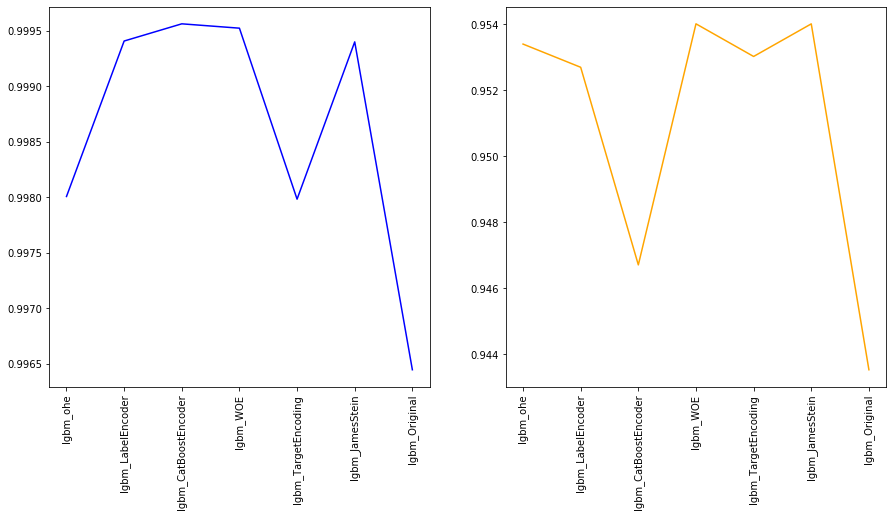

In [185]:
fig = plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.plot(results.loc["train-score"], color="blue")
plt.xticks(ticks=results.columns, rotation=90)

plt.subplot(122)
plt.plot(results.loc["valid-score"], color="orange")
plt.xticks(ticks=results.columns, rotation=90)
plt.show()

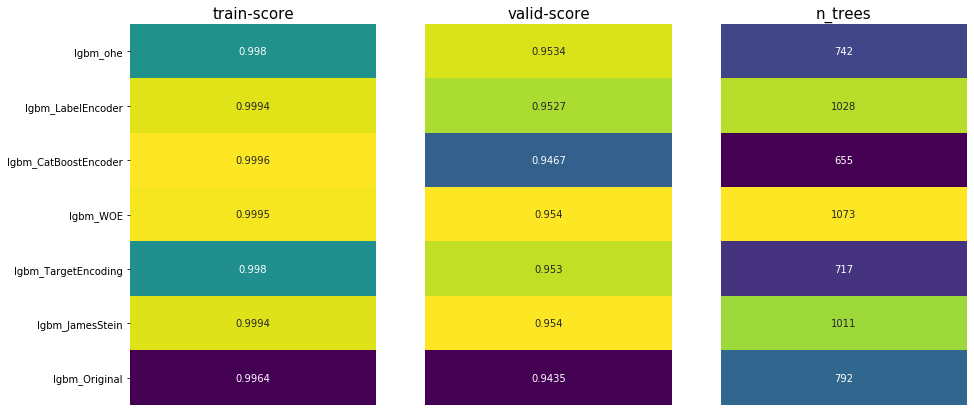

In [193]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 7))

for num, param in enumerate(results.index):
    if num > 0:
        yticklabels = False
    else:
        yticklabels = "auto"
    sns.heatmap(results.loc[param, :].to_frame(),
                cmap="viridis",
                annot=True,
                xticklabels=False,
                yticklabels=yticklabels,
                fmt='.4g', ax=ax[num], cbar=False
    )
    ax[num].set_title(param, fontsize=15)

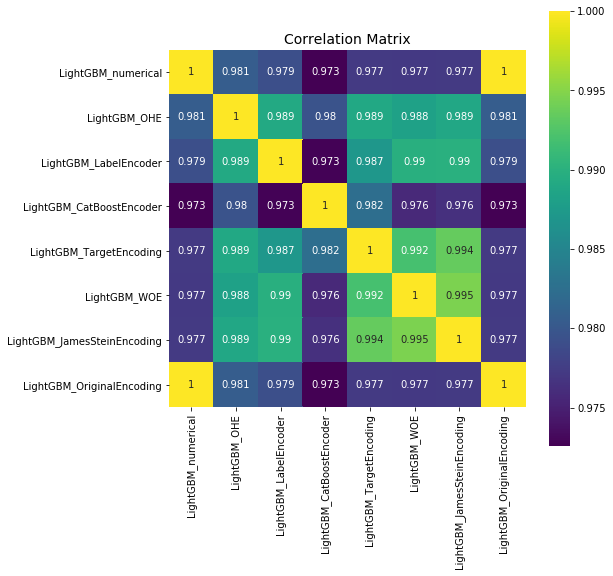

In [233]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_title("Correlation Matrix", fontsize=14)
sns.heatmap(valid_predictions.corr(), cmap="viridis", annot=True, fmt='.3g', square=True, ax=axes)

Text(0.5, 0.98, 'ROC-Curve for LightGBM with different CategoricalEncoders')

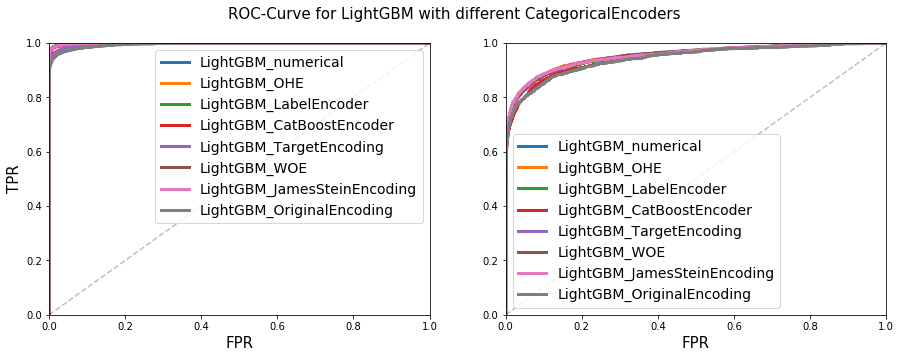

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for data in train_predictions.columns:
    for num, (y_score, target) in enumerate(
        zip([train_predictions[data], valid_predictions[data]], [y_train, y_valid])):
        fpr, tpr, _ = roc_curve(target, y_score)
        plt.subplot(int(f"12{num+1}"))
        plt.plot(fpr, tpr, linewidth=3, label=data)
        plt.legend(loc="best", fontsize=14)

plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.25)
plt.xlabel("FPR", size=15)
plt.ylabel("TPR", size=15)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplot(122)
plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.25)
plt.xlabel("FPR", size=15)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.suptitle("ROC-Curve for LightGBM with different CategoricalEncoders", size=15)